In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
import pickle
import os
from google.colab import files

from PIL import Image
import scipy.ndimage
import pandas as pd
import seaborn as sns
import gc
import time

import tensorflow as tf
from tensorflow import keras
# import keras_tuner as kt
from keras import layers
print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.15.0


In [13]:
def select_labels(label_val, label_train_full, label_test_full):
  indexes_train_full = np.where((label_train_full == label_val[0]) | (label_train_full == label_val[1]))[0]
  indexes_test = np.where((label_test_full == label_val[0]) | (label_test_full == label_val[1]))[0]
  return indexes_train_full, indexes_test

def split_train_calib_dataset(img_train_full, label_train_full, indexes_train_full, index_max_train, nb_calib):
  index_max=indexes_train_full.shape[0]
  index_max_calib=min(index_max_train+nb_calib,index_max)
  indexes_train = indexes_train_full[0:index_max_train]
  indexes_calib = indexes_train_full[index_max_train+1:index_max_calib+1]
  indexes_unkno = indexes_train_full[index_max_calib+2:]
  img_train = img_train_full[indexes_train]
  img_calib = img_train_full[indexes_calib]
  img_unkno = img_train_full[indexes_unkno]
  lab_train = label_train_full[indexes_train]
  lab_calib = label_train_full[indexes_calib]
  lab_unkno = label_train_full[indexes_unkno]
  return img_train, lab_train, img_calib, lab_calib, img_unkno, lab_unkno

def labels_dichotomize(label_val, lab_train, lab_test):
  lab_train[lab_train[:]==label_val[0]]=0
  lab_train[lab_train[:]==label_val[1]]=1
  lab_test[lab_test[:]==label_val[0]]=0
  lab_test[lab_test[:]==label_val[1]]=1

def labels_dichotomize_calib(label_val, lab_calib, lab_unkno):
  lab_calib[lab_calib[:]==label_val[0]]=0
  lab_calib[lab_calib[:]==label_val[1]]=1
  lab_unkno[lab_unkno[:]==label_val[0]]=0
  lab_unkno[lab_unkno[:]==label_val[1]]=1

In [14]:
# (img_train_full, label_train_full), (img_test_full, label_test_full) = keras.datasets.fashion_mnist.load_data()
(img_train_full, label_train_full), (img_test_full, label_test_full) = tf.keras.datasets.cifar10.load_data()
# (img_train_full, label_train_full), (img_test_full, label_test_full) = tf.keras.datasets.mnist.load_data()
indexes_train_full = tf.range(0,label_train_full.shape[0])
print(indexes_train_full)
indexes_test = tf.range(0,label_test_full.shape[0])
print(indexes_test)
#indexes_train_full, indexes_test = select_labels(label_val, label_train_full, label_test_full):

# index_max_train=index_max
index_max_train = 25000
# index_max_train = 25
nb_calib = 5000
# nb_calib = 100
img_train, lab_train, img_calib, lab_calib, img_unkno, lab_unkno = split_train_calib_dataset(img_train_full, label_train_full, indexes_train_full, index_max_train, nb_calib)

img_test = img_test_full[indexes_test]
lab_test = label_test_full[indexes_test]

#label_val = [1,7]
#labels_dichotomize(label_val, lab_train, lab_calib, lab_unkno, lab_test)

del(img_train_full)
del(label_train_full)
del(img_test_full)
del(label_test_full)
gc.collect()

batch_size = 24

tf.Tensor([    0     1     2 ... 49997 49998 49999], shape=(50000,), dtype=int32)
tf.Tensor([   0    1    2 ... 9997 9998 9999], shape=(10000,), dtype=int32)


In [15]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_calib = img_calib.astype('float32') / 255.0
img_unkno = img_unkno.astype('float32') / 255.0
img_test  = img_test.astype('float32') / 255.0

print(f' taille image sets: train = {img_train.shape}, calib = {img_calib.shape}, unknown = {img_unkno.shape}, test = {img_test.shape}')
img_shape = img_train[0].shape
print(f' taille image = {img_shape}')
print(f' taille label sets: train = {lab_train.shape}, calib = {lab_calib.shape}, unknown = {lab_unkno.shape}, test = {lab_test.shape}')

 taille image sets: train = (25000, 32, 32, 3), calib = (5000, 32, 32, 3), unknown = (19998, 32, 32, 3), test = (10000, 32, 32, 3)
 taille image = (32, 32, 3)
 taille label sets: train = (25000, 1), calib = (5000, 1), unknown = (19998, 1), test = (10000, 1)


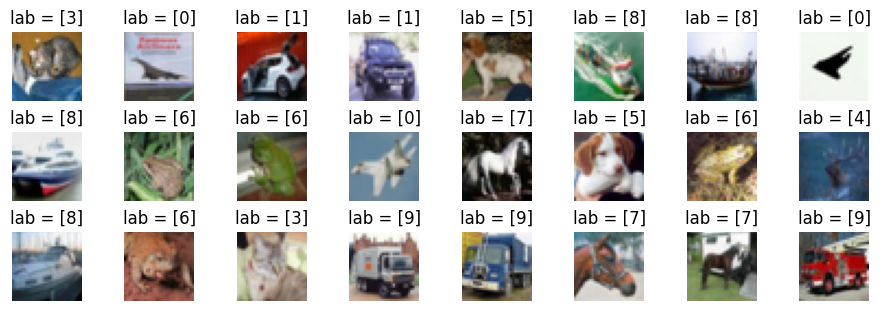

In [16]:
def affiche_24images_lab(img_set, lab_set):
  ncol_aff = 8
  nrow_aff = 3
  fig, axs = plt.subplots(ncols=ncol_aff, nrows=nrow_aff, figsize=(9,3), layout="constrained")
  for no_im in range(ncol_aff*nrow_aff):
    i = int(no_im%nrow_aff)
    j = int(no_im/nrow_aff)
    axs[i,j].set_title(f'lab = {lab_set[no_im]}')
    axs[i,j].imshow(img_set[no_im])
    axs[i,j].axis('off')
  plt.show()

affiche_24images_lab(img_test, lab_test)

In [17]:
def plot_history(Hist):
  fig = plt.figure(1)
# summarize history for accuracy
  fig.add_subplot(1,2,1)
  plt.plot(Hist['accuracy'])
  plt.plot(Hist['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
  fig.add_subplot(1,2,2)
  plt.plot(Hist['loss'])
  plt.plot(Hist['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [18]:
def make_model_1():
  model_cnn = tf.keras.models.Sequential([
   # tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'),
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', name='Conv2D_1'),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_1'),
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_2'),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_2'),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='Dense_1'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform', name='Dense_2')
  ])
  assert model_cnn.output_shape == (None, 10)
  return model_cnn

model_cnn_1 = make_model_1()
model_cnn_1.summary()

# print(f' model_cnn.trainable_variables : {model_cnn.trainable_variables}')

image = np.copy(img_train[0])
print(image.shape, image[np.newaxis, ...].shape)
decision = model_cnn_1.predict(image[np.newaxis, ...])
print (decision)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 10, 10, 16)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 3, 3, 16)          0         
                                                                 
 Flatten (Flatten)           (None, 144)               0         
                                                                 
 Dense_1 (Dense)             (None, 128)               18560     
                                                                 
 Dense_2 (Dense)             (None, 10)               

Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 2.2233 - accuracy: 0.1807 - val_loss: 2.0469 - val_accuracy: 0.2768
Epoch 2/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9440 - accuracy: 0.2934 - val_loss: 1.8337 - val_accuracy: 0.3452
Epoch 3/50
625/625 [==============================] - 2s 4ms/step - loss: 1.7956 - accuracy: 0.3534 - val_loss: 1.7340 - val_accuracy: 0.3776
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 1.7145 - accuracy: 0.3875 - val_loss: 1.6663 - val_accuracy: 0.4008
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 1.6579 - accuracy: 0.4052 - val_loss: 1.6312 - val_accuracy: 0.4112
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 1.6182 - accuracy: 0.4216 - val_loss: 1.5937 - val_accuracy: 0.4268
Epoch 7/50
625/625 [==============================] - 2s 4ms/step - loss: 1.5834 - accuracy: 0.4367 - val_loss: 1.5649 - val_accuracy: 0.4402
Epoch 

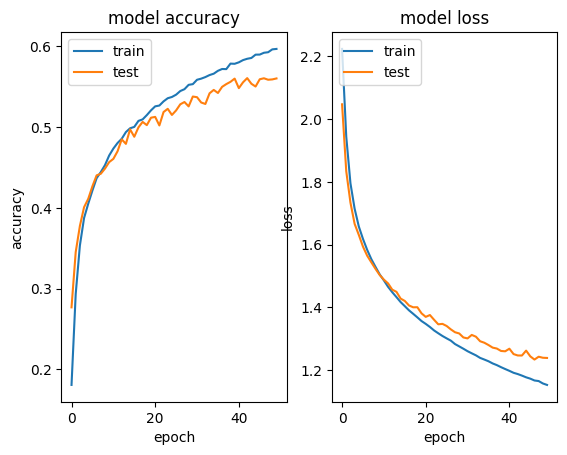

313/313 - 1s - loss: 1.2499 - accuracy: 0.5569 - 604ms/epoch - 2ms/step
 Model, accuracy: 55.69000244140625
417/417 [==============================] - 1s 2ms/step
tf.Tensor(
[[513  28  61  24  42  12  21  18 223  58]
 [ 55 576   9  20  15   7  22  15  88 193]
 [ 73  17 333  80 184  77 108  63  42  23]
 [ 17  15  72 416  95 133 137  63  32  20]
 [ 32   3  59  55 543  35 137 101  29   6]
 [ 12   9  61 231  90 399  62  87  35  14]
 [  7  10  37  65  68  12 761  18  12  10]
 [ 24   4  25  61 123  55  34 617  18  39]
 [ 70  48  11  23  12   3  10   6 789  28]
 [ 38 129  14  25  17  13  26  32  84 622]], shape=(10, 10), dtype=int32)


In [19]:
reload = 0
if (reload):
  # Loads the weights
  model_cnn_1 = tf.keras.models.load_model('sample_data/model_cnn1_25k.h5')
  loss, acc = model_cnn_1.evaluate(img_test, lab_test, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_cnn1 = tf.argmax(model_cnn_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_cnn = tf.math.confusion_matrix(lab_test,predictions_cnn1)
  print(conf_mat_cnn)
else:
  model_cnn_1 = make_model_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_cnn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_cnn_1.compile(optimizer=model_optimizer, loss=loss_cnn, metrics=['accuracy'])
  h = model_cnn_1.fit(img_train[...], lab_train, epochs=50, validation_split=0.2)
  History_cnn = h.history
  print(History_cnn.keys())
  plot_history(History_cnn)
  model_cnn_1.save('model_cnn1_25k.h5')
  loss, acc = model_cnn_1.evaluate(img_test, lab_test, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_cnn1 = tf.argmax(model_cnn_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_cnn = tf.math.confusion_matrix(lab_test,predictions_cnn1)
  print(conf_mat_cnn)

In [20]:
def ambiguous_classes(conf_mat, th_amb):
  print(conf_mat)
  nb_classes = conf_mat.shape[0]
  conf_mat2 = np.copy(conf_mat)
  tab_amb_cl = np.zeros((nb_classes,3))
  n = 0
  for i in range(nb_classes):
    j2 = -1
    xmax = 0
    for j in range(nb_classes):
      if j!=i:
        x = (conf_mat2[i,j]+conf_mat2[j,i])/(conf_mat2[i,i]+conf_mat2[j,j])
        if (x>xmax):
          j2=j
          xmax = x
    if xmax>th_amb:
      print(f' ambiguous classes : {i} & {j2} -> ambiguity = {xmax*100} %')
      k_min = min(i,j2)
      k_max = max(i,j2)
      nn = 0
      deja = False
      for nn in range(n):
        if (int(tab_amb_cl[nn,0]) == k_min):
          deja = True
      if (deja == False):
        tab_amb_cl[n,0] = k_min
        tab_amb_cl[n,1] = k_max
        tab_amb_cl[n,2] = xmax
        n = n+1
  return tab_amb_cl, n

ambiguous_classes(conf_mat_cnn, 0.25)

tf.Tensor(
[[513  28  61  24  42  12  21  18 223  58]
 [ 55 576   9  20  15   7  22  15  88 193]
 [ 73  17 333  80 184  77 108  63  42  23]
 [ 17  15  72 416  95 133 137  63  32  20]
 [ 32   3  59  55 543  35 137 101  29   6]
 [ 12   9  61 231  90 399  62  87  35  14]
 [  7  10  37  65  68  12 761  18  12  10]
 [ 24   4  25  61 123  55  34 617  18  39]
 [ 70  48  11  23  12   3  10   6 789  28]
 [ 38 129  14  25  17  13  26  32  84 622]], shape=(10, 10), dtype=int32)
 ambiguous classes : 1 & 9 -> ambiguity = 26.878130217028378 %
 ambiguous classes : 2 & 4 -> ambiguity = 27.73972602739726 %
 ambiguous classes : 3 & 5 -> ambiguity = 44.66257668711656 %
 ambiguous classes : 4 & 2 -> ambiguity = 27.73972602739726 %
 ambiguous classes : 5 & 3 -> ambiguity = 44.66257668711656 %
 ambiguous classes : 9 & 1 -> ambiguity = 26.878130217028378 %


(array([[1.   , 9.   , 0.269],
        [2.   , 4.   , 0.277],
        [3.   , 5.   , 0.447],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ]]),
 3)

In [21]:
def make_model_2():
  model_fc = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3), strides=(3,3), kernel_initializer='he_uniform', name='Conv_1'),
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', strides=(5,5), kernel_initializer='he_uniform', name='Conv_2'),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name='Dense_1'),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='Dense_2'),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='Dense_3'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform', name='Dense_4')
  ])
  assert model_fc.output_shape == (None, 10)
  return model_fc

model_fc_1 = make_model_2()
model_fc_1.summary()

# print(f' model_cnn.trainable_variables : {model_cnn.trainable_variables}')

image = np.copy(img_train[0])
print(image.shape, image[np.newaxis, ...].shape)
decision = model_fc_1.predict(image[np.newaxis, ...])
print (decision)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 11, 11, 64)        1792      
                                                                 
 Conv_2 (Conv2D)             (None, 3, 3, 64)          102464    
                                                                 
 Flatten (Flatten)           (None, 576)               0         
                                                                 
 Dense_1 (Dense)             (None, 256)               147712    
                                                                 
 Dense_2 (Dense)             (None, 128)               32896     
                                                                 
 Dense_3 (Dense)             (None, 64)                8256      
                                                                 
 Dense_4 (Dense)             (None, 10)               

Epoch 1/20
625/625 [==============================] - 6s 6ms/step - loss: 1.9647 - accuracy: 0.2923 - val_loss: 1.7457 - val_accuracy: 0.3846
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 1.6641 - accuracy: 0.4072 - val_loss: 1.6022 - val_accuracy: 0.4294
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 1.5266 - accuracy: 0.4560 - val_loss: 1.4778 - val_accuracy: 0.4680
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 1.4374 - accuracy: 0.4848 - val_loss: 1.4301 - val_accuracy: 0.4928
Epoch 5/20
625/625 [==============================] - 3s 4ms/step - loss: 1.3693 - accuracy: 0.5098 - val_loss: 1.3951 - val_accuracy: 0.5072
Epoch 6/20
625/625 [==============================] - 3s 4ms/step - loss: 1.3161 - accuracy: 0.5324 - val_loss: 1.3618 - val_accuracy: 0.5156
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - loss: 1.2623 - accuracy: 0.5530 - val_loss: 1.3451 - val_accuracy: 0.5200
Epoch 

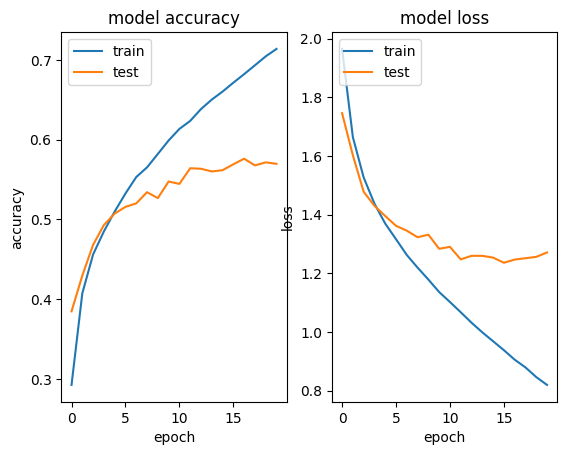

313/313 - 1s - loss: 1.2887 - accuracy: 0.5554 - 750ms/epoch - 2ms/step
 Model, accuracy: 55.5400013923645
417/417 [==============================] - 1s 2ms/step
tf.Tensor(
[[723  31  37  20  35   6  23  27  78  20]
 [ 70 731  11  17  15   4  15  11  43  83]
 [ 97  13 304  69 266  66  94  60  18  13]
 [ 33  14  71 331 138 157 152  57  25  22]
 [ 47   6  70  42 626  26  86  83  10   4]
 [ 19   8  68 176 129 404  86  89  17   4]
 [ 13   8  32  44 156  14 688  27  10   8]
 [ 38  11  36  46 134  65  21 618   8  23]
 [164  79  18  22  23  11  11   9 645  18]
 [ 84 217  11  18  20  19  33  63  51 484]], shape=(10, 10), dtype=int32)
tf.Tensor(
[[723  31  37  20  35   6  23  27  78  20]
 [ 70 731  11  17  15   4  15  11  43  83]
 [ 97  13 304  69 266  66  94  60  18  13]
 [ 33  14  71 331 138 157 152  57  25  22]
 [ 47   6  70  42 626  26  86  83  10   4]
 [ 19   8  68 176 129 404  86  89  17   4]
 [ 13   8  32  44 156  14 688  27  10   8]
 [ 38  11  36  46 134  65  21 618   8  23]
 [164  79  

(array([[2.   , 4.   , 0.361],
        [3.   , 5.   , 0.453],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ]]),
 2)

In [22]:
reload = 0
if (reload):
  # Loads the weights
  model_fc_1 = tf.keras.models.load_model('sample_data/model_fc1_25k.h5')
  loss, acc = model_fc_1.evaluate(img_test, lab_test, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_fc1 = tf.argmax(model_fc_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_fc = tf.math.confusion_matrix(lab_test,predictions_fc1)
  print(conf_mat_cnn)
else:
  model_fc_1 = make_model_2()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_fc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_fc_1.compile(optimizer=model_optimizer, loss=loss_fc, metrics=['accuracy'])
  h = model_fc_1.fit(img_train[...], lab_train, epochs=20, validation_split=0.2)
  History_fc = h.history
  print(History_fc.keys())
  plot_history(History_fc)
  model_fc_1.save('model_fc1_25k.h5')
  loss, acc = model_fc_1.evaluate(img_test, lab_test, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_fc1 = tf.argmax(model_fc_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_fc = tf.math.confusion_matrix(lab_test,predictions_fc1)
  print(conf_mat_fc)

ambiguous_classes(conf_mat_fc, 0.25)

In [23]:
def calc_betP(bbas):
  powerset_card = bbas.shape[1]
  n_classes = int(np.log2(powerset_card))
  n_samples = bbas.shape[0]
  betp = np.zeros((bbas.shape[0],n_classes))
  card = np.zeros(powerset_card)
  # début à coder (~10 lignes)

  # fin à coder
  return betp

powerset_card = 1024
bbas2 = np.ones((1,powerset_card))
bbas2 = bbas2/powerset_card
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.zeros((1,powerset_card))
bbas2[0,powerset_card-1]=1
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.ones((1,powerset_card))
i = 3
i_in = np.zeros(powerset_card)
for j in range(powerset_card):
  i_in[j] = np.bitwise_and(j,2**i)/2**i
print(i_in)
bbas2[0,:] = i_in/(powerset_card/2)
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.zeros((1,2**3))
prob = [[0.1, 0.5, 0.4]]
print(f' prob = {prob}')
i = 2**3-1
bbas2[0,i] = 0.1*3
j = 0
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.4-0.1)*2
j = 2
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.5-0.4)*1
print(f' mass = {bbas2}')
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.zeros((1,powerset_card))
prob = [[0.1, 0.01, 0.2, 0.11, 0.01, 0.01, 0.4, 0.1, 0.05, 0.01]]
print(f' prob = {prob}')
i = powerset_card-1
bbas2[0,i] = 0.01*10
j = 9
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.01-0.01)*9
j = 5
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.01-0.01)*8
j = 4
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.01-0.01)*7
j = 1
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.05-0.01)*6
j = 8
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.1-0.05)*5
j = 7
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.1-0.1)*4
j = 0
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.11-0.1)*3
j = 3
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.2-0.11)*2
j = 2
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.4-0.2)*1
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

 sum masses = [1.]
 betP = [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
 sum masses = [1.]
 betP = [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
[0. 0. 0. ... 1. 1. 1.]
 sum masses = [1.]
 betP = [[0.089 0.089 0.089 0.2   0.089 0.089 0.089 0.089 0.089 0.089]]
 prob = [[0.1, 0.5, 0.4]]
 mass = [[0.  0.  0.1 0.  0.  0.  0.6 0.3]]
 sum masses = [1.]
 betP = [[0.1 0.5 0.4]]
 prob = [[0.1, 0.01, 0.2, 0.11, 0.01, 0.01, 0.4, 0.1, 0.05, 0.01]]
 sum masses = [1.]
 betP = [[0.1  0.01 0.2  0.11 0.01 0.01 0.4  0.1  0.05 0.01]]


In [24]:
def verif_mass(bbas):
  sum = np.sum(bbas,axis=1)
  return sum

def alloc_consonant_bba(predictions):
  predicts = np.copy(predictions)
  n_samples = predictions.shape[0]
  n_classes = predictions.shape[1]
  powerset_card = 2**n_classes
  bbas = np.zeros((n_samples,powerset_card))
  for n in range(n_samples):
  # début à coder (~15 lignes)

  # fin à coder
  return bbas

predictions_cnn1 = model_cnn_1.predict(img_test[:5])
print(f' predictions = {predictions_cnn1}')
bbas_cnn1 = alloc_consonant_bba(predictions_cnn1)
print(f' betP = {calc_betP(bbas_cnn1)}')

1/1 [==============================] - 0s 129ms/step
 predictions = [[0.001 0.005 0.058 0.451 0.011 0.288 0.152 0.002 0.028 0.004]
 [0.019 0.108 0.    0.    0.    0.    0.    0.    0.862 0.011]
 [0.319 0.044 0.004 0.006 0.002 0.001 0.001 0.001 0.595 0.027]
 [0.076 0.035 0.006 0.003 0.003 0.    0.    0.    0.866 0.011]
 [0.    0.    0.017 0.045 0.64  0.015 0.262 0.021 0.001 0.   ]]
 betP = [[0.001 0.005 0.058 0.451 0.011 0.288 0.152 0.002 0.028 0.004]
 [0.019 0.108 0.    0.    0.    0.    0.    0.    0.862 0.011]
 [0.319 0.044 0.004 0.006 0.002 0.001 0.001 0.001 0.595 0.027]
 [0.076 0.035 0.006 0.003 0.003 0.    0.    0.    0.866 0.011]
 [0.    0.    0.017 0.045 0.64  0.015 0.262 0.021 0.001 0.   ]]


In [25]:
def conjunctive_rule(bbas1, bbas2):
  if bbas2.shape[1] != bbas1.shape[1]:
    return np.zeros((1,1))
  else:
    powerset_card = bbas1.shape[1]
    n_classes = int(np.log2(powerset_card))
    n_samples = min(bbas1.shape[0], bbas2.shape[0])
    bbas12 = np.zeros((n_samples,powerset_card))
  # début à coder (4 lignes)

  # fin à coder
  return bbas12

print(f' betP = {calc_betP(bbas_cnn1)}')
bbas_cnn1_conj = conjunctive_rule(bbas_cnn1, bbas_cnn1)
print(f' mass sum = {verif_mass(bbas_cnn1_conj)}')
print(f' betP = {calc_betP(bbas_cnn1_conj)}')


 betP = [[0.001 0.005 0.058 0.451 0.011 0.288 0.152 0.002 0.028 0.004]
 [0.019 0.108 0.    0.    0.    0.    0.    0.    0.862 0.011]
 [0.319 0.044 0.004 0.006 0.002 0.001 0.001 0.001 0.595 0.027]
 [0.076 0.035 0.006 0.003 0.003 0.    0.    0.    0.866 0.011]
 [0.    0.    0.017 0.045 0.64  0.015 0.262 0.021 0.001 0.   ]]
 mass sum = [1. 1. 1. 1. 1.]
 betP = [[0.    0.    0.018 0.589 0.001 0.289 0.098 0.    0.005 0.   ]
 [0.001 0.03  0.    0.    0.    0.    0.    0.    0.969 0.   ]
 [0.255 0.009 0.    0.    0.    0.    0.    0.    0.732 0.004]
 [0.019 0.005 0.    0.    0.    0.    0.    0.    0.975 0.001]
 [0.    0.    0.002 0.01  0.799 0.001 0.186 0.003 0.    0.   ]]


In [26]:
# première fusion : juste les classifieurs 10 classes
nb_samples = 1000
sample_0 = 000
nb_lab = 10
lab_b = tf.one_hot(lab_test[sample_0:sample_0+nb_samples,0], nb_lab)

scores_cnn1 = model_cnn_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_cnn1 = alloc_consonant_bba(scores_cnn1)

scores_fc1 = model_fc_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_fc1 = alloc_consonant_bba(scores_fc1)

bbas_cnn1_conj_fc1 = conjunctive_rule(bbas_cnn1, bbas_fc1)
betP_cnn1_conj_fc1 = calc_betP(bbas_cnn1_conj_fc1)
dec_b_cnn1_conj_fc1 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1,axis=1), nb_lab)

acc_cnn1_conj_fc1 = np.sum(lab_b*dec_b_cnn1_conj_fc1)/(nb_samples)
print(f' acc_cnn1_conj_fc1 = {acc_cnn1_conj_fc1}')

loss_cnn1s, acc_cnn1s = model_cnn_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_cnn1s = {acc_cnn1s}')
loss_fc1s, acc_fc1s = model_fc_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_fc1s = {acc_fc1s}')

32/32 [==============================] - 0s 2ms/step
 acc_cnn1_conj_fc1 = 0.584
32/32 - 0s - loss: 1.2612 - accuracy: 0.5450 - 112ms/epoch - 4ms/step
 acc_cnn1s = 0.5450000166893005
32/32 - 0s - loss: 1.2708 - accuracy: 0.5500 - 134ms/epoch - 4ms/step
 acc_fc1s = 0.550000011920929


(10000,) (10000,) (10000,)
 (10000, 32, 32, 3) (10000, 1) (2000, 32, 32, 3) (2000, 1)
 (10000, 32, 32, 3) (10000, 1) (2000, 32, 32, 3) (2000, 1)
 (10000, 32, 32, 3) (10000, 1) (2000, 32, 32, 3) (2000, 1)


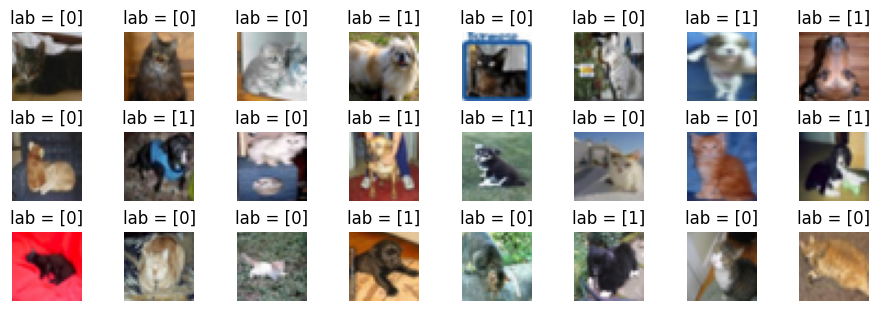

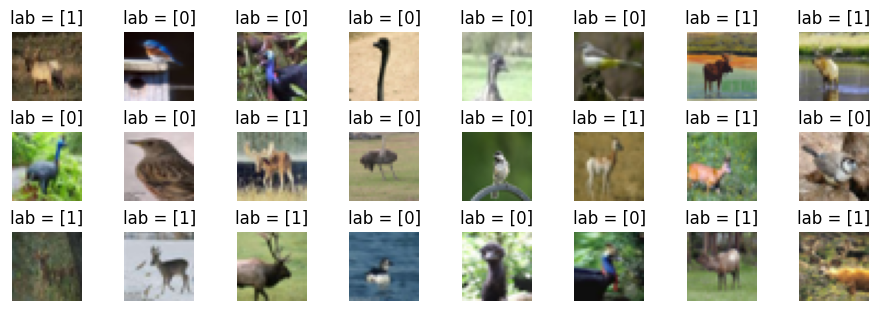

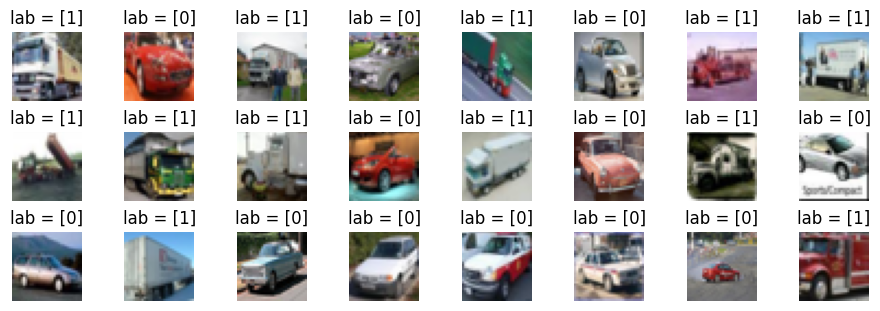

In [29]:
(img_train_full, label_train_full), (img_test_full, label_test_full) = tf.keras.datasets.cifar10.load_data()

label_val35 = [3,5]
label_val19 = [1,9]
label_val24 = [2,4]

indexes_train_full35, indexes_test35 = select_labels(label_val35, label_train_full, label_test_full)
indexes_train_full24, indexes_test24 = select_labels(label_val24, label_train_full, label_test_full)
indexes_train_full19, indexes_test19 = select_labels(label_val19, label_train_full, label_test_full)
print(indexes_train_full35.shape, indexes_train_full24.shape, indexes_train_full19.shape)

img_train35 = img_train_full[indexes_train_full35]
lab_train35 = label_train_full[indexes_train_full35]
# print(img_train_full.shape, img_train35.shape, lab_train35.shape, img_train19.shape, lab_train19.shape)
img_test35 = img_test_full[indexes_test35]
lab_test35 = label_test_full[indexes_test35]
labels_dichotomize(label_val35, lab_train35, lab_test35)
print(f' {img_train35.shape} {lab_train35.shape} {img_test35.shape} {lab_test35.shape}')

img_train24 = img_train_full[indexes_train_full24]
lab_train24 = label_train_full[indexes_train_full24]
img_test24 = img_test_full[indexes_test24]
lab_test24 = label_test_full[indexes_test24]
labels_dichotomize(label_val24, lab_train24, lab_test24)
print(f' {img_train24.shape} {lab_train24.shape} {img_test24.shape} {lab_test24.shape}')

img_train19 = img_train_full[indexes_train_full19]
lab_train19 = label_train_full[indexes_train_full19]
img_test19 = img_test_full[indexes_test19]
lab_test19 = label_test_full[indexes_test19]
labels_dichotomize(label_val19, lab_train19, lab_test19)
print(f' {img_train19.shape} {lab_train19.shape} {img_test19.shape} {lab_test19.shape}')

del(img_train_full)
del(label_train_full)
del(img_test_full)
del(label_test_full)
gc.collect()

batch_size = 24
affiche_24images_lab(img_train35, lab_train35)
affiche_24images_lab(img_train24, lab_train24)
affiche_24images_lab(img_train19, lab_train19)

# Normalize pixel values between 0 and 1
img_train35 = img_train35.astype('float32') / 255.0
img_train24 = img_train24.astype('float32') / 255.0
img_train19 = img_train19.astype('float32') / 255.0
img_test35 = img_test35.astype('float32') / 255.0
img_test24 = img_test24.astype('float32') / 255.0
img_test19 = img_test19.astype('float32') / 255.0

In [30]:
def make_dichotomizer_1():
  model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', name='Conv2D_1'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_3'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_1'),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_4'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_2'),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_5'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='Dense_1'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='Dense_2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='Dense_3')
  ])
  assert model_cnn.output_shape == (None, 2)
  return model_cnn

model_dichoto = make_dichotomizer_1()
model_dichoto.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 10, 10, 32)       

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 7s 9ms/step - loss: 1.1507 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 2/100
250/250 [==============================] - 2s 9ms/step - loss: 0.7397 - accuracy: 0.5009 - val_loss: 0.6939 - val_accuracy: 0.4955
Epoch 3/100
250/250 [==============================] - 2s 6ms/step - loss: 0.7046 - accuracy: 0.5230 - val_loss: 0.6931 - val_accuracy: 0.4965
Epoch 4/100
250/250 [==============================] - 2s 6ms/step - loss: 0.7015 - accuracy: 0.5185 - val_loss: 0.6934 - val_accuracy: 0.4980
Epoch 5/100
250/250 [==============================] - 2s 7ms/step - loss: 0.6962 - accuracy: 0.5239 - val_loss: 0.6933 - val_accuracy: 0.4965
Epoch 6/100
250/250 [==============================] - 2s 8ms/step - loss: 0.6961 - accuracy: 0.5284 - val_loss: 0.6926 - val_accuracy: 0.4980
Epoch 7/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6923 - accuracy: 0.5316 - val_loss: 0.6923 - val_accuracy: 0.5020
Epoch 8/100

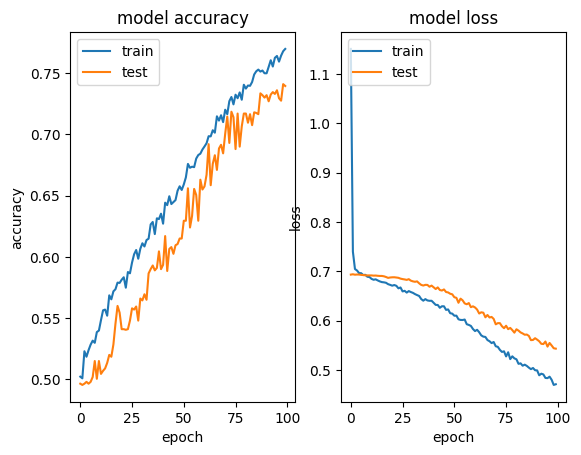

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 - 0s - loss: 0.5347 - accuracy: 0.7485 - 311ms/epoch - 5ms/step
 Model, accuracy: 74.84999895095825
84/84 [==============================] - 1s 7ms/step
tf.Tensor(
[[754 246]
 [257 743]], shape=(2, 2), dtype=int32)


In [31]:
reload = 0
if (reload):
  # Loads the weights
  model_dichoto_35 = tf.keras.models.load_model('sample_data/model_di35_25k.h5')
  loss, acc = model_dichoto_35.evaluate(img_test35, lab_test35, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_di35 = tf.argmax(model_dichoto_35.predict(img_test35, batch_size=batch_size),axis=1)
  conf_mat_di35 = tf.math.confusion_matrix(lab_test35, predictions_di35)
  print(conf_mat_di35)
else:
  model_dichoto_35 = make_dichotomizer_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_dicho = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_dichoto_35.compile(optimizer=model_optimizer, loss=loss_dicho, metrics=['accuracy'])
  h = model_dichoto_35.fit(img_train35, lab_train35, epochs=100, validation_split=0.2)
  History_di35 = h.history
  print(History_di35.keys())
  plot_history(History_di35)
  model_dichoto_35.save('model_di35_25k.h5')
  loss, acc = model_dichoto_35.evaluate(img_test35, lab_test35, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_di35 = tf.argmax(model_dichoto_35.predict(img_test35, batch_size=batch_size),axis=1)
  conf_mat_di35 = tf.math.confusion_matrix(lab_test35, predictions_di35)
  print(conf_mat_di35)

Epoch 1/100
250/250 [==============================] - 5s 9ms/step - loss: 0.8023 - accuracy: 0.5186 - val_loss: 0.6895 - val_accuracy: 0.5800
Epoch 2/100
250/250 [==============================] - 2s 7ms/step - loss: 0.6991 - accuracy: 0.5312 - val_loss: 0.6895 - val_accuracy: 0.5815
Epoch 3/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6849 - accuracy: 0.5601 - val_loss: 0.6860 - val_accuracy: 0.6080
Epoch 4/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6789 - accuracy: 0.5729 - val_loss: 0.6844 - val_accuracy: 0.6050
Epoch 5/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6718 - accuracy: 0.5801 - val_loss: 0.6806 - val_accuracy: 0.5990
Epoch 6/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6645 - accuracy: 0.5909 - val_loss: 0.6766 - val_accuracy: 0.6215
Epoch 7/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6610 - accuracy: 0.6025 - val_loss: 0.6755 - val_accuracy: 0.6120

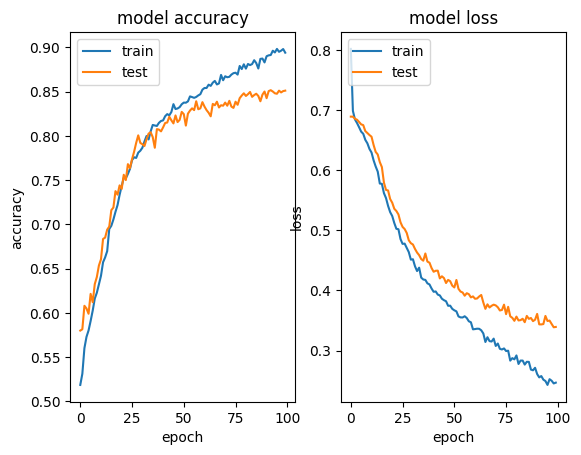

63/63 - 0s - loss: 0.3307 - accuracy: 0.8645 - 156ms/epoch - 2ms/step
 Model, accuracy: 86.44999861717224
84/84 [==============================] - 0s 2ms/step
tf.Tensor(
[[855 145]
 [126 874]], shape=(2, 2), dtype=int32)


In [32]:
reload = 0
if (reload):
  # Loads the weights
  model_dichoto_24 = tf.keras.models.load_model('sample_data/model_di24_25k.h5')
  loss, acc = model_dichoto_24.evaluate(img_test24, lab_test24, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_di24 = tf.argmax(model_dichoto_24.predict(img_test24, batch_size=batch_size),axis=1)
  conf_mat_di24 = tf.math.confusion_matrix(lab_test24, predictions_di24)
  print(conf_mat_di24)
else:
  model_dichoto_24 = make_dichotomizer_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_dicho = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_dichoto_24.compile(optimizer=model_optimizer, loss=loss_dicho, metrics=['accuracy'])
  h = model_dichoto_24.fit(img_train24, lab_train24, epochs=100, validation_split=0.2)
  History_di24 = h.history
  print(History_di24.keys())
  plot_history(History_di24)
  model_dichoto_24.save('model_di24_25k.h5')
  loss, acc = model_dichoto_24.evaluate(img_test24, lab_test24, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_di24 = tf.argmax(model_dichoto_24.predict(img_test24, batch_size=batch_size),axis=1)
  conf_mat_di24 = tf.math.confusion_matrix(lab_test24, predictions_di24)
  print(conf_mat_di24)

Epoch 1/100
250/250 [==============================] - 4s 7ms/step - loss: 0.9436 - accuracy: 0.5341 - val_loss: 0.6839 - val_accuracy: 0.6125
Epoch 2/100
250/250 [==============================] - 2s 8ms/step - loss: 0.7053 - accuracy: 0.5638 - val_loss: 0.6838 - val_accuracy: 0.6275
Epoch 3/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6756 - accuracy: 0.5819 - val_loss: 0.6832 - val_accuracy: 0.6090
Epoch 4/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6599 - accuracy: 0.6054 - val_loss: 0.6806 - val_accuracy: 0.6115
Epoch 5/100
250/250 [==============================] - 2s 7ms/step - loss: 0.6558 - accuracy: 0.6127 - val_loss: 0.6782 - val_accuracy: 0.6130
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 0.6485 - accuracy: 0.6135 - val_loss: 0.6762 - val_accuracy: 0.6240
Epoch 7/100
250/250 [==============================] - 2s 7ms/step - loss: 0.6378 - accuracy: 0.6313 - val_loss: 0.6708 - val_accuracy: 0.635

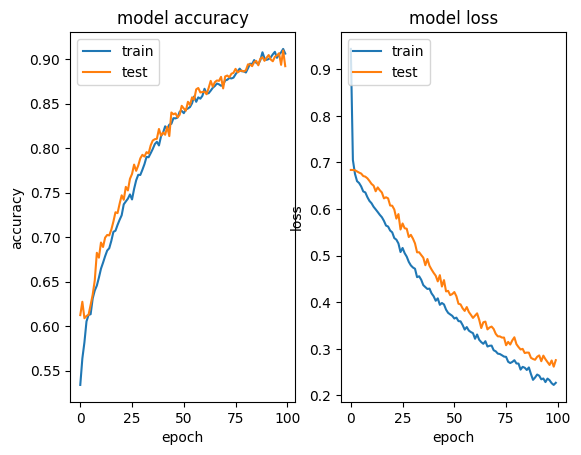

63/63 - 0s - loss: 0.2761 - accuracy: 0.8890 - 147ms/epoch - 2ms/step
 Model, accuracy: 88.89999985694885
84/84 [==============================] - 0s 2ms/step
tf.Tensor(
[[923  77]
 [145 855]], shape=(2, 2), dtype=int32)


In [33]:
reload = 0
if (reload):
  # Loads the weights
  model_dichoto_19 = tf.keras.models.load_model('sample_data/model_di19_25k.h5')
  loss, acc = model_dichoto_19.evaluate(img_test19, lab_test19, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_di19 = tf.argmax(model_dichoto_19.predict(img_test19, batch_size=batch_size),axis=1)
  conf_mat_di19 = tf.math.confusion_matrix(lab_test19, predictions_di19)
  print(conf_mat_di19)
else:
  model_dichoto_19 = make_dichotomizer_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_dicho = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_dichoto_19.compile(optimizer=model_optimizer, loss=loss_dicho, metrics=['accuracy'])
  h = model_dichoto_19.fit(img_train19, lab_train19, epochs=100, validation_split=0.2)
  History_di19 = h.history
  print(History_di19.keys())
  plot_history(History_di19)
  model_dichoto_19.save('model_di19_25k.h5')
  loss, acc = model_dichoto_19.evaluate(img_test19, lab_test19, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_di19 = tf.argmax(model_dichoto_19.predict(img_test19, batch_size=batch_size),axis=1)
  conf_mat_di19 = tf.math.confusion_matrix(lab_test19, predictions_di19)
  print(conf_mat_di19)

In [34]:
def affiche_bba(bba, nb_lab):
  for k in range(2**nb_lab):
    if (bba[k]>0):
      print(f' k = {np.binary_repr(k,nb_lab)}, m(k) = {bba[k]}')

def discount_bbas(bbas, alpha):
  powerset_card = 2**n_classes
  # print(f' n_samples = {n_samples}, n_classes = {n_classes}, powerset_card = {powerset_card}')
  bbas = bbas*alpha
  bbas[:,powerset_card-1] = bbas[:,powerset_card-1]+1-alpha
  print(verif_mass(bbas))
  return bbas

# correction des bbas 10 classes pour les classes ambigues
def merge_2cl_bbas(bbas,nb_lab,i,j):
  # début à coder (4 lignes)

  # fin à coder
  return bbas

def alloc_dichoto_bba(predictions, n_classes, label_val):
  predicts = np.copy(predictions)
  n_samples = predictions.shape[0]
  powerset_card = 2**n_classes
  bbas = np.zeros((n_samples,powerset_card))
  for n in range(n_samples):
  # début à coder (4 lignes)

  # fin à coder
  return bbas

n_classes = 10
predictions_di35 = model_dichoto_35.predict(img_test35[:5])
print(f' predictions = {predictions_di35}')
bbas_di35 = alloc_dichoto_bba(predictions_di35, n_classes, label_val35)
print(f' betP = {calc_betP(bbas_di35)}')
predictions_di19 = model_dichoto_19.predict(img_test19[:5])
print(f' predictions = {predictions_di19}')
bbas_di19 = alloc_dichoto_bba(predictions_di19, n_classes, label_val19)
print(f' betP = {calc_betP(bbas_di19)}')
affiche_bba(bbas_di19[0], nb_lab)

alpha = 0.2
print(f' alpha = {alpha} => {discount_bbas(bbas_di19, alpha)}')
affiche_bba(discount_bbas(bbas_di19, alpha)[0], nb_lab)

1/1 [==============================] - 0s 215ms/step
 predictions = [[0.623 0.377]
 [0.624 0.376]
 [0.412 0.588]
 [0.229 0.771]
 [0.393 0.607]]
 betP = [[0.111 0.111 0.111 0.069 0.111 0.042 0.111 0.111 0.111 0.111]
 [0.111 0.111 0.111 0.069 0.111 0.042 0.111 0.111 0.111 0.111]
 [0.111 0.111 0.111 0.046 0.111 0.065 0.111 0.111 0.111 0.111]
 [0.111 0.111 0.111 0.025 0.111 0.086 0.111 0.111 0.111 0.111]
 [0.111 0.111 0.111 0.044 0.111 0.067 0.111 0.111 0.111 0.111]]
1/1 [==============================] - 0s 18ms/step
 predictions = [[0.996 0.004]
 [0.912 0.088]
 [0.04  0.96 ]
 [0.028 0.972]
 [0.324 0.676]]
 betP = [[0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.   ]
 [0.111 0.101 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.01 ]
 [0.111 0.004 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.107]
 [0.111 0.003 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.108]
 [0.111 0.036 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.075]]
 k = 0111111111, m(k) = 0.9962434768676758
 k = 1111111101, m(k) 

In [35]:
nb_samples = 1000
sample_0 = 000
nb_lab = 10
lab_b = tf.one_hot(lab_test[sample_0:sample_0+nb_samples,0], nb_lab)

loss_cnn1s, acc_cnn1s = model_cnn_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_cnn1s = {acc_cnn1s}')
scores_cnn1 = model_cnn_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_cnn1 = alloc_consonant_bba(scores_cnn1)

loss_fc1s, acc_fc1s = model_fc_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_fc1s = {acc_fc1s}')
scores_fc1 = model_fc_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_fc1 = alloc_consonant_bba(scores_fc1)

bbas_cnn1_conj_fc1 = conjunctive_rule(bbas_cnn1, bbas_fc1)
betP_cnn1_conj_fc1 = calc_betP(bbas_cnn1_conj_fc1)
dec_b_cnn1_conj_fc1 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1,axis=1), nb_lab)
acc_cnn1_conj_fc1 = np.sum(lab_b*dec_b_cnn1_conj_fc1)/(nb_samples)
print(f' acc_cnn1_conj_fc1 = {acc_cnn1_conj_fc1}')

bbas_cnn1b = merge_2cl_bbas(bbas_cnn1,nb_lab,int(label_val35[0]),int(label_val35[1]))
bbas_cnn1c = merge_2cl_bbas(bbas_cnn1b,nb_lab,int(label_val24[0]),int(label_val24[1]))
bbas_cnn1d = merge_2cl_bbas(bbas_cnn1c,nb_lab,int(label_val19[0]),int(label_val19[1]))
bbas_fc1b = merge_2cl_bbas(bbas_fc1,nb_lab,int(label_val35[0]),int(label_val35[1]))
bbas_fc1c = merge_2cl_bbas(bbas_fc1b,nb_lab,int(label_val24[0]),int(label_val24[1]))
bbas_fc1d = merge_2cl_bbas(bbas_fc1c,nb_lab,int(label_val19[0]),int(label_val19[1]))
# alpha = 0.1
bbas_cnn1_conj_fc1 = conjunctive_rule(bbas_cnn1d, bbas_fc1d)

predictions_di35 = model_dichoto_35.predict(img_test[sample_0:sample_0+nb_samples])
bbas_di35 = alloc_dichoto_bba(predictions_di35, nb_lab, label_val35)
predictions_di24 = model_dichoto_24.predict(img_test[sample_0:sample_0+nb_samples])
bbas_di24 = alloc_dichoto_bba(predictions_di24, nb_lab, label_val24)
predictions_di19 = model_dichoto_19.predict(img_test[sample_0:sample_0+nb_samples])
bbas_di19 = alloc_dichoto_bba(predictions_di19, nb_lab, label_val19)

debug = 0
if debug:
  bbas_cnn1_conj_fc1_di35 = conjunctive_rule(bbas_di35, bbas_cnn1_conj_fc1)
  betP_cnn1_conj_fc1_di35 = calc_betP(bbas_cnn1_conj_fc1_di35)
  dec_b_cnn1_conj_fc1_di35 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1_di35,axis=1), nb_lab)
  acc_cnn1_conj_fc1_di35 = np.sum(lab_b*dec_b_cnn1_conj_fc1_di35)/(nb_samples)
  print(f' acc_cnn1_conj_fc1_di35 = {acc_cnn1_conj_fc1_di35}')
  bbas_cnn1_conj_fc1_di19 = conjunctive_rule(bbas_di19, bbas_cnn1_conj_fc1)
  betP_cnn1_conj_fc1_di19 = calc_betP(bbas_cnn1_conj_fc1_di19)
  dec_b_cnn1_conj_fc1_di19 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1_di19,axis=1), nb_lab)
  acc_cnn1_conj_fc1_di19 = np.sum(lab_b*dec_b_cnn1_conj_fc1_di19)/(nb_samples)
  print(f' acc_cnn1_conj_fc1_di19 = {acc_cnn1_conj_fc1_di19}')

bbas_cnn1_conj_fc1_di35 = conjunctive_rule(bbas_di35, bbas_cnn1_conj_fc1)
bbas_cnn1_conj_fc1_di35_di24 = conjunctive_rule(bbas_di24, bbas_cnn1_conj_fc1_di35)
bbas_cnn1_conj_fc1_di35_di24_di19 = conjunctive_rule(bbas_di19, bbas_cnn1_conj_fc1_di35_di24)
betP_cnn1_conj_fc1_di35_di24_di19 = calc_betP(bbas_cnn1_conj_fc1_di35_di24_di19)
dec_b_cnn1_conj_fc1_di35_di24_di19 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1_di35_di24_di19,axis=1), nb_lab)
acc_cnn1_conj_fc1_di35_di24_di19 = np.sum(lab_b*dec_b_cnn1_conj_fc1_di35_di24_di19)/(nb_samples)
print(f' acc_cnn1_conj_fc1_di35_di24_di19 = {acc_cnn1_conj_fc1_di35_di24_di19}')

32/32 - 0s - loss: 1.2612 - accuracy: 0.5450 - 76ms/epoch - 2ms/step
 acc_cnn1s = 0.5450000166893005
32/32 [==============================] - 0s 2ms/step
32/32 - 0s - loss: 1.2708 - accuracy: 0.5500 - 89ms/epoch - 3ms/step
 acc_fc1s = 0.550000011920929
32/32 [==============================] - 0s 2ms/step
 acc_cnn1_conj_fc1 = 0.584
 i = 3 = 0000001000, j = 5 = 0000100000 => iUj = 40 = 0000101000
 i = 2 = 0000000100, j = 4 = 0000010000 => iUj = 20 = 0000010100
 i = 1 = 0000000010, j = 9 = 1000000000 => iUj = 514 = 1000000010
 i = 3 = 0000001000, j = 5 = 0000100000 => iUj = 40 = 0000101000
 i = 2 = 0000000100, j = 4 = 0000010000 => iUj = 20 = 0000010100
 i = 1 = 0000000010, j = 9 = 1000000000 => iUj = 514 = 1000000010
32/32 [==============================] - 0s 2ms/step
 acc_cnn1_conj_fc1_di35_di24_di19 = 0.628
